<a href="https://colab.research.google.com/github/SchrOdinger11/RecommendationMusic/blob/main/MusicRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')



Mounted at /content/drive


Importing and Installing Packages

In [11]:
!pip install mtcnn
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN
import numpy as np
from numpy import savez_compressed
from keras.models import load_model 


Face Detection Task

In [6]:
def gettheface(image):
  detector = MTCNN()     #image passed as parameter
  img = Image.open(image)        #opening the image using PIL module    
  img = img.convert('RGB')       #convert the image into RGB format  
  pixelsofimage = asarray(img)             #convert the pixels in image to an array 
                #object of mtcnn class
  f = detector.detect_faces( pixelsofimage)   #detect_face function of mtcnn
  print(f)
  #create a bounding box top lef coordinates x1,y1 followed by width w and height h  
  #f is a dictionary with multiple elements and we need to store the coordinates of box from it
  x,y,width,height = f[0]['box']           
  x, y = abs(x), abs(y)
  x_f = abs(x+width)
  y_f = abs(y+height)
  face_gotten =  pixelsofimage [y:y_f,x:x_f] #store faces shown by the coordinate system.
  plt.imshow(face_gotten)
  image1 = Image.fromarray(face_gotten,'RGB')   
  image1 = image1.resize((160,160))             
  face = asarray(image1)             
  return face

def facesfromdirectory(dy):
  face = []
  i=1
  for filename in listdir(dy):
    path = dy + filename
    faces = gettheface(path)
    face.append(faces)
  return face

Load the Dataset

In [ ]:
def load_dataset(directory):
  x, y = [],[]
  i=1
  
  for subdir in listdir(directory):
    path = directory + subdir + '/'
    faces = facesfromdirectory(path)
    labels = [subdir for _ in range(len(faces))]
    print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
    x.extend(faces)
    y.extend(labels)
    i=i+1
  return asarray(x),asarray(y)  

trainX,trainY = load_dataset('/content/drive/MyDrive/Indian-celebrities/')


In [ ]:
print(trainX.shape,trainY.shape)
savez_compressed('/content/drive/MyDrive/MusicDataset/PROJECTS/face recog + mood/Indian-celeb-dataset.npz',trainX,trainY)


Face Recognition

Function for Generating embeddings from the face


In [11]:

import numpy as np
def getthoseembeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')  
  mean = face_pixels.mean()                   
  std  = face_pixels.std()                #normalization of image pixels    
  face_pixels = (face_pixels - mean)/std       
  samples = np.expand_dims(face_pixels,axis=0)    
  yhat = model.predict(samples)
  #disp(yhat[0])
  return yhat[0]

Load the data and run extract_embedding function


In [ ]:
data = np.load('/content/drive/MyDrive/MusicDataset/PROJECTS/face recog + mood/Indian-celeb-dataset.npz')
trainx, trainy = data['arr_0'],data['arr_1']
#print(trainx)
#print(trainy)
print(trainx.shape, trainy.shape)

model = load_model('/content/drive/MyDrive/MusicDataset/model/facenet_keras.h5')
#128 pixel values

#get the face embeddings
new_trainx = list()
for train_pixels in trainx:
  embeddings = getthoseembeddings(model,train_pixels)
  new_trainx.append(embeddings)
new_trainx = np.asarray(new_trainx)            
print(new_trainx.shape)
print(new_trainx)
#save the arrays in compressed format
savez_compressed('/content/drive/MyDrive/MusicDataset/PROJECTS/Indian-celeb-embeddings.npz',new_trainx,trainy)

## Model Train from the embeddings 

[{'box': [335, 32, 87, 122], 'confidence': 0.9999803304672241, 'keypoints': {'left_eye': (359, 82), 'right_eye': (400, 82), 'nose': (379, 108), 'mouth_left': (360, 125), 'mouth_right': (398, 124)}}]
Input test data shape:  (400, 735, 3)
Input test embedding shape:  (1, 128)
Loaded data: Train=1538 , Test=1


Text(0.5, 0, 'Detected Face')

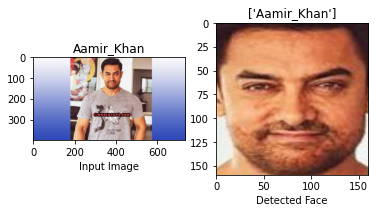

In [12]:
from matplotlib import pyplot as plt
from PIL import Image
from numpy import asarray
from numpy import array
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import expand_dims
from numpy import reshape
from numpy import load
from numpy import max
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import matplotlib.image as mpimg

Img = '/content/drive/MyDrive/MusicDataset/Indian-celebrities/Aamir_Khan/Aamir_Khan_8.jpg'

face = gettheface(Img)

input_image=mpimg.imread(Img)


plt.imshow(input_image)

testx = face.reshape(-1,160,160,3)
print("Input test data shape: ",input_image.shape)




#find embeddings
model = load_model('/content/drive/MyDrive/MusicDataset/model/facenet_keras.h5')
new_testx = list()
for test_pixels in testx:
  embeddings =  getthoseembeddings(model,test_pixels)
  new_testx.append(embeddings)
new_testx = asarray(new_testx)  
print("Input test embedding shape: ",new_testx.shape)

data1 = load('/content/drive/MyDrive/MusicDataset/PROJECTS/face recog + mood/Indian-celeb-dataset.npz')
train_x,train_y = data1['arr_0'],data1['arr_1']

data = load('/content/drive/MyDrive/MusicDataset/PROJECTS/Indian-celeb-embeddings.npz')
trainx,trainy= data['arr_0'],data['arr_1']
print("Loaded data: Train=%d , Test=%d"%(trainx.shape[0],new_testx.shape[0]))

#normalize the input 
in_encode = Normalizer(norm='l2')
trainx = in_encode.transform(trainx)
new_testx = in_encode.transform(new_testx)

#create label vector
out_encode = LabelEncoder()
out_encode.fit(trainy)
trainy = out_encode.transform(trainy)

#svm classifier model 
model =SVC(kernel='linear', probability=True)
model.fit(trainx,trainy)

#predict
predict_train = model.predict(trainx)
predict_test = model.predict(new_testx)

#Accuracy
acc_train = accuracy_score(trainy,predict_train)

#display
trainy_list = list(trainy)
p=int(predict_test)
if p in trainy_list:
  val = trainy_list.index(p)

#display Predicated data
plt.subplot(1,2,1)
plt.imshow(input_image)  
trainy = out_encode.inverse_transform(trainy)
plt.title(trainy[val])
plt.xlabel("Input Image")
#display Input Image
plt.subplot(1,2,2)
plt.imshow(face)
predict_test = out_encode.inverse_transform(predict_test)
plt.title(predict_test)
plt.xlabel("Detected Face")


TESTING-FACE DETECTION 

[{'box': [480, 101, 230, 307], 'confidence': 0.999995231628418, 'keypoints': {'left_eye': (539, 209), 'right_eye': (648, 211), 'nose': (590, 269), 'mouth_left': (549, 327), 'mouth_right': (636, 331)}}]
(667, 1200, 3)


Text(0.5, 1.0, "['Akshay_Kumar']")

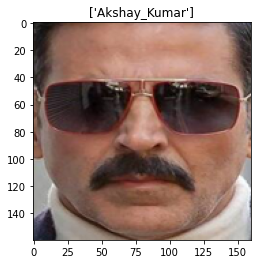

In [13]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
loaded_model = pickle.load(open('/content/drive/MyDrive/MusicDataset/model/SVMmodel.sav', 'rb'))
facenet=load_model('/content/drive/MyDrive/MusicDataset/model/facenet_keras.h5')
Img ='/content/drive/MyDrive/MusicDataset/PROJECTS/testing/testingimg/akshay-kumar-1200.jpg'
#'/content/drive/MyDrive/MusicDataset/Indian-celebrities/Akshay_Kumar/Akshay_Kumar_0.jpg'
#plt.imshow(Img)
face = gettheface(Img)
testx = face.reshape(-1,160,160,3)
new_testx = list()
for test_pixels in testx:
  embeddings = getthoseembeddings(facenet,test_pixels)
  new_testx.append(embeddings)
new_testx = asarray(new_testx)
import cv2
img = cv2. imread(Img)

#ref data for label encoding
data = np.load('/content/drive/MyDrive/MusicDataset/PROJECTS/Indian-celeb-embeddings.npz')
trainx,trainy= data['arr_0'],data['arr_1']
out_encode = LabelEncoder()
out_encode.fit(trainy)

in_encode = Normalizer(norm='l2')
new_testx = in_encode.transform(new_testx)
predict_test = loaded_model.predict(new_testx)
#plt.imshow(Img)
from google.colab.patches import cv2_imshow
print(img.shape)
#cv2_imshow(img.resize(img,(160,160)))
plt.imshow(face)
predict_test = out_encode.inverse_transform(predict_test)
plt.title(predict_test)

In [ ]:
print(acc_train) #SVC classifier

0.9986996098829649


In [ ]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/MusicDataset/model/SVMmodel.sav', 'wb'))

MOOD PREDICTIONS

In [16]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os

num_classes=5
img_rows,img_cols=48,48
batch_size=128

train_data_dir='/content/drive/MyDrive/MusicDataset/PROJECTS/face recog + mood/fer2013/train'
validation_data_dir='/content/drive/MyDrive/MusicDataset/PROJECTS/face recog + mood/fer2013/validation'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        color_mode='grayscale',
                        target_size=(img_rows,img_cols),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                                validation_data_dir,
                                color_mode='grayscale',
                                target_size=(img_rows,img_cols),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=True)

Found 28353 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


In [18]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

In [14]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('/content/drive/MyDrive/MusicDataset/PROJECTS/face recog + mood/EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

epochs=2

history=model.fit(train_generator, epochs=epochs,callbacks=callbacks,validation_data=validation_generator)
             
                
               
                
loss_train = history.history['train_loss']
loss_val = history.history['val_loss']
epochs = range(1,35)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TESTING-EmotionDetector

In [9]:
#TESTING
from keras.models import load_model
import pickle
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)   
class_labels=['Angry','Happy','Neutral','Sad','Surprise']

emotiondetection=load_model('/content/drive/MyDrive/MusicDataset/model/EmotionDetectionModelV2.h5')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: Operation cancelled by user


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[{'box': [363, 176, 82, 100], 'confidence': 0.9952207207679749, 'keypoints': {'left_eye': (395, 210), 'right_eye': (424, 228), 'nose': (403, 240), 'mouth_left': (377, 246), 'mouth_right': (401, 261)}}]


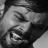

Angry
##################################################################################
[{'box': [362, 479, 294, 384], 'confidence': 0.9999996423721313, 'keypoints': {'left_eye': (424, 619), 'right_eye': (559, 620), 'nose': (471, 701), 'mouth_left': (430, 763), 'mouth_right': (549, 772)}}]


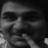

Happy
##################################################################################
[{'box': [193, 926, 235, 294], 'confidence': 0.9999978542327881, 'keypoints': {'left_eye': (260, 1038), 'right_eye': (362, 1043), 'nose': (297, 1096), 'mouth_left': (256, 1151), 'mouth_right': (345, 1156)}}]


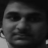

Sad
##################################################################################
[{'box': [315, 103, 461, 605], 'confidence': 1.0, 'keypoints': {'left_eye': (430, 357), 'right_eye': (646, 368), 'nose': (522, 477), 'mouth_left': (435, 584), 'mouth_right': (612, 593)}}, {'box': [294, 605, 69, 84], 'confidence': 0.9886192083358765, 'keypoints': {'left_eye': (316, 636), 'right_eye': (348, 644), 'nose': (325, 656), 'mouth_left': (308, 668), 'mouth_right': (335, 676)}}]


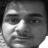

Neutral
##################################################################################
[{'box': [105, 245, 289, 388], 'confidence': 0.9999972581863403, 'keypoints': {'left_eye': (186, 387), 'right_eye': (317, 414), 'nose': (235, 476), 'mouth_left': (158, 507), 'mouth_right': (301, 536)}}]


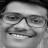

Happy
##################################################################################
[{'box': [25, 68, 234, 289], 'confidence': 0.9999589920043945, 'keypoints': {'left_eye': (76, 178), 'right_eye': (182, 187), 'nose': (112, 250), 'mouth_left': (67, 278), 'mouth_right': (177, 288)}}]


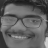

Happy
##################################################################################


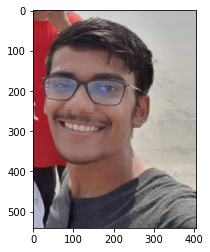

In [12]:
!pip install curtsies
import cv2
from google.colab.patches import cv2_imshow
from curtsies.fmtfuncs import red, green, yellow, blue, cyan
for i in range(1,7):
  Img = f'/content/drive/MyDrive/MusicDataset/PROJECTS/testing/testingimg/{i}.jpg'
  face = gettheface(Img)
  face=cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  face=cv2.resize(face, (48,48), interpolation = cv2.INTER_AREA)
  plt.imshow(Image.open(Img))
  cv2_imshow(face)
  face=face.astype('float')/255.0
  face=img_to_array(face)
  face=np.expand_dims(face,axis=0)
  preds=emotdet.predict(face)
 
  pred=preds[0]
  print(cyan(class_labels[pred.argmax()]))
  print('##################################################################################')

MUSIC RECOMMENDATION

In [2]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

data=pd.read_csv('/content/drive/MyDrive/MusicDataset/PROJECTS/data_spotifyV2.csv')
data.drop_duplicates(inplace=True,subset=['name'])
name=data['name'] #input
col_features = ['danceability', 'energy', 'valence', 'loudness'] #features which affect type of music
X = MinMaxScaler().fit_transform(data[col_features]) #stabilize value of input features
print(X)
kmeans = KMeans(init="k-means++",
                n_clusters=3,
                random_state=15).fit(X)
data['kmeans'] = kmeans.labels_
data['song_name']=name

[[0.65085772 0.445      0.127      0.71374816]
 [0.70131181 0.263      0.655      0.57917279]
 [0.43794147 0.177      0.457      0.59379589]
 ...
 [0.77194753 0.663      0.686      0.83787628]
 [0.53985873 0.314      0.0663     0.72162567]
 [0.70232089 0.615      0.438      0.82274841]]


In [4]:

orig_data=data.copy()

In [5]:
cluster=data.groupby(by=data['kmeans'])
y=data.pop('kmeans')
print(y)
x=data.drop(columns=['name','artists','id','release_date','song_name','id_artists'])

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)
model=LGBMClassifier().fit(x_train,y_train)
model.score(x_train,y_train)
y_pred=model.predict(x_test);

0         1
1         1
2         1
3         1
4         1
         ..
586665    1
586667    1
586668    2
586669    1
586670    0
Name: kmeans, Length: 446475, dtype: int32


In [6]:
model.score(x_test,y_test)

0.9950994006396761

In [7]:
df=cluster.apply(lambda x: x.sort_values(["popularity"],ascending=False))
df.reset_index(level=0, inplace=True)

In [8]:
EMOTIONS = ["happy","sad","unknown"]
  
def get_results(emotion_code, NUM_RECOMMEND=10):
  happy_set=[]
  sad_set=[]
  unknown_set=[]
  if emotion_code==0:
      happy_set.append(df[df['kmeans']==1]['song_name'].head(NUM_RECOMMEND))
      return pd.DataFrame(happy_set).T
  elif emotion_code==2:
      unknown_set.append(df[df['kmeans']==2]['song_name'].head(NUM_RECOMMEND))
      return pd.DataFrame(unknown_set).T
  else:
      sad_set.append(df[df['kmeans']==0]['song_name'].head(NUM_RECOMMEND))
      return pd.DataFrame(sad_set).T
  # print(len(happy_set))
  # print(len(sad_set))
  # print(len(unknown_set))

Testing the music recommendations based on emotion

In [13]:
#emotion_word=cyan(class_labels[pred.argmax()]).lower()
emotion_word='Angry'
print(emotion_word)
NUM_RECOMMEND=int(input("Enter number of recommendations: "))
if emotion_word=='Sad':
    emotion_code=0
elif emotion_word=='Angry':
    emotion_code=2
else:
    emotion_code=1
results= get_results(emotion_code,NUM_RECOMMEND)
print(results)
print(emotion_code)

Angry
Enter number of recommendations: 5
                                               song_name
92810                                    Save Your Tears
92811                                          telepatía
93805                                Leave The Door Open
93807  Friday (feat. Mufasa & Hypeman) - Dopamine Re-...
93809                                                 Up
2


In [10]:
ids=[]
import numpy as np
for x in np.asarray(results):
  print(x)
  ids.append(orig_data[orig_data['name']==x[0]]['id'])

['Save Your Tears']
['telepatía']
['Leave The Door Open']
['Friday (feat. Mufasa & Hypeman) - Dopamine Re-Edit']


Result Analysis

[[28087    64   110]
 [   72 35844    85]
 [  144    72 47141]]


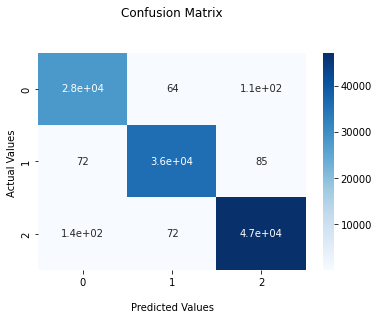

In [11]:
import matplotlib.pyplot as plt
y_pred=model.predict(x_test);
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

In [ ]:

!pip install spotipy


In [ ]:
!pip install helpers